# Reference API for the nw2vec model

## Imports and setup

In [1]:
import time
import random
import os

import numpy as np
import scipy as sp
import scipy.stats
import sklearn.preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import networkx as nx

import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback as TQDMCallback

from progressbar import ProgressBar
from IPython.display import SVG, HTML, display

from nw2vec import ae
from nw2vec import utils
from nw2vec import codecs
from nw2vec import layers
from nw2vec import viz
from nw2vec import batching

Using TensorFlow backend.


In [2]:
random.seed(1)
np.random.seed(1)

## Drawing the predictions

In [3]:
def plot_ξ_kde(glk, q_pred_ξ_sample, ix_iy, palette, ax):
    g, l, k = glk
    ix, iy = ix_iy
    
    for i in range(l):
        x = q_pred_ξ_sample[i * k:(i + 1) * k, :, ix].flatten()
        y = q_pred_ξ_sample[i * k:(i + 1) * k, :, iy].flatten()
        sb.kdeplot(x, y, cmap=sb.light_palette(palette[i], as_cmap=True),
                   shade=True, shade_lowest=False, ax=ax)
    ax.set_title(r'$\xi_{{{ix}}} \sim \xi_{{{iy}}}$ density'.format(ix=ix, iy=iy))

def plot_ξ_μ(q_pred_μ, ix_iy, communities, palette, ax):
    ix, iy = ix_iy
    
    ax.scatter(q_pred_μ[:, ix], q_pred_μ[:, iy], s=250, c=palette[communities])
    for i, (x, y) in enumerate(q_pred_μ[:, [ix, iy]]):
        ax.text(x, y, str(i), ha='center', va='center', color='white')
    ax.set_title(r'$\mu_{{{ix}}} \sim \mu_{{{iy}}}$'.format(ix=ix, iy=iy))

In [4]:
def plot_ξ_distribution(glk, q_model, q_codecs, adj, features):
    assert len(q_codecs) == 1
    q_codec = q_codecs[0]
    
    g, l, k = glk
    palette = np.concatenate([np.array(sb.color_palette(n_colors=l)),
                              .5 * np.ones((l, 1))],
                             axis=1)
    communities = ([[i] for i in range(l)] * np.ones((l, k), dtype=np.int32)).reshape(-1)

    q_pred = q_model.predict_fullbatch(adj=adj, features=features)
    q_pred_ξ_sample = K.eval(codecs.get_nocache(q_codec, q_pred).stochastic_value(100))
    dim_ξ = q_pred_ξ_sample.shape[-1]
    assert dim_ξ >= 2
    q_pred_μ = q_pred[:, :dim_ξ]
    
    fig, axes = plt.subplots(dim_ξ - 1, dim_ξ - 1, figsize=(4 * (dim_ξ - 1), 4 * (dim_ξ - 1)), sharex=True, sharey=True)

    for ix in range(dim_ξ - 1):
        for iy in range(ix):
            axes[ix, iy].set_visible(False)
        for iy in range(ix + 1, dim_ξ):
            ax = axes[ix, iy - 1]
            
            # KDE plot
            plot_ξ_kde(glk, q_pred_ξ_sample, (ix, iy), palette, ax)
            
            ## Inset μ plot
            #inset = inset_axes(ax, width="40%", height="40%", loc=4)
            #inset.tick_params(labelleft=False, labelbottom=False)
            #plot_ξ_μ(q_pred_μ, (ix, iy), communities, palette, inset)
            #
            ## Box representing the μ plots in the KDE plots
            #ax.hlines(inset.get_ylim(), *inset.get_xlim(), colors='lightgrey')
            #ax.vlines(inset.get_xlim(), *inset.get_ylim(), colors='lightgrey')

In [5]:
def plot_predictions(model, adj, features):
    q_pred, adj_pred, v_pred = model.predict_fullbatch(adj=adj, features=features)
    adj_pred_mean = scipy.special.expit(adj_pred).mean(axis=1)[0]
    v_pred_mean = scipy.special.expit(v_pred).mean(axis=1)

    # Embeddings
    fig, ax = plt.subplots(figsize=(4, 4 * n_nodes / 25))
    im = ax.imshow(q_pred)
    ax.set_title('Embeddings')
    plt.colorbar(im, ax=ax)

    # Adjacency matrix
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    im1 = ax1.imshow(nx.adjacency_matrix(g).toarray())
    ax1.set_title('Real adj')
    plt.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(adj_pred_mean)
    im2.set_norm(im1.norm)
    ax2.set_title('Predicted adj')
    plt.colorbar(im2, ax=ax2)
    
    im3 = ax3.imshow(np.random.binomial(1, adj_pred_mean))
    im3.set_norm(im1.norm)
    ax3.set_title('Sampled predicted adj')
    plt.colorbar(im3, ax=ax3)

    # Features
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4 * n_nodes / 25))

    im1 = ax1.imshow(labels)
    ax1.set_title('Real labels')
    plt.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(features)
    ax2.set_title('Features ( = noisy labels)')
    plt.colorbar(im2, ax=ax2)

    im3 = ax3.imshow(v_pred_mean)
    im3.set_norm(im1.norm)
    ax3.set_title('Predicted labels')
    plt.colorbar(im3, ax=ax3)
    
    im4 = ax4.imshow(np.random.binomial(1, v_pred_mean))
    im4.set_norm(im1.norm)
    ax4.set_title('Sampled predicted labels')
    plt.colorbar(im4, ax=ax4)

## Test graph

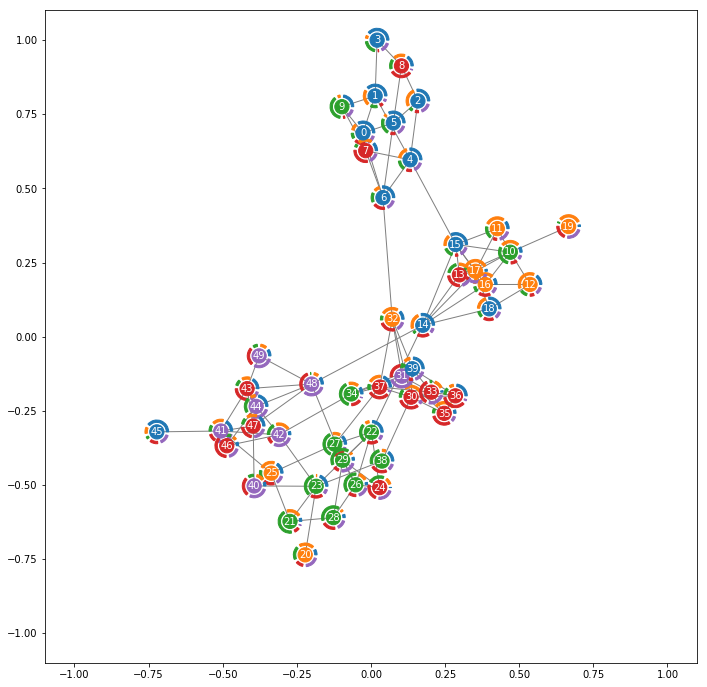

In [6]:
# Parameters
l = 5
k = 10
p_in = .4
p_out = .01
g = nx.planted_partition_graph(l, k, p_in, p_out)

# Show the graph
labels = np.zeros((l * k, l), dtype=np.float32)
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1

features = labels + np.abs(np.random.normal(loc=0.0, scale=1.5, size=(l * k, l))).astype(np.float32)
viz.draw_network(g, labels=features);

## Build the VAE

In [7]:
# VAE Parameters
n_nodes = l * k
adj = nx.adjacency_matrix(g).astype(np.float32)

n_ξ_samples = 5
dim_data, dim_l1, dim_ξ = l, 10, 4
dims = (dim_data, dim_l1, dim_ξ)

# Actual VAE
q_model, q_codecs = ae.build_q(dims, fullbatcher=batching.fullbatches, minibatcher=batching.pq_batches)
p_builder = ae.build_p_builder(dims, embedding_slices=[slice(2), slice(2, 4)], share_l1=False)
vae, vae_codecs = ae.build_vae(
    (q_model, q_codecs), p_builder,
    n_ξ_samples,
    loss_weights=[1, 1, 10]
)

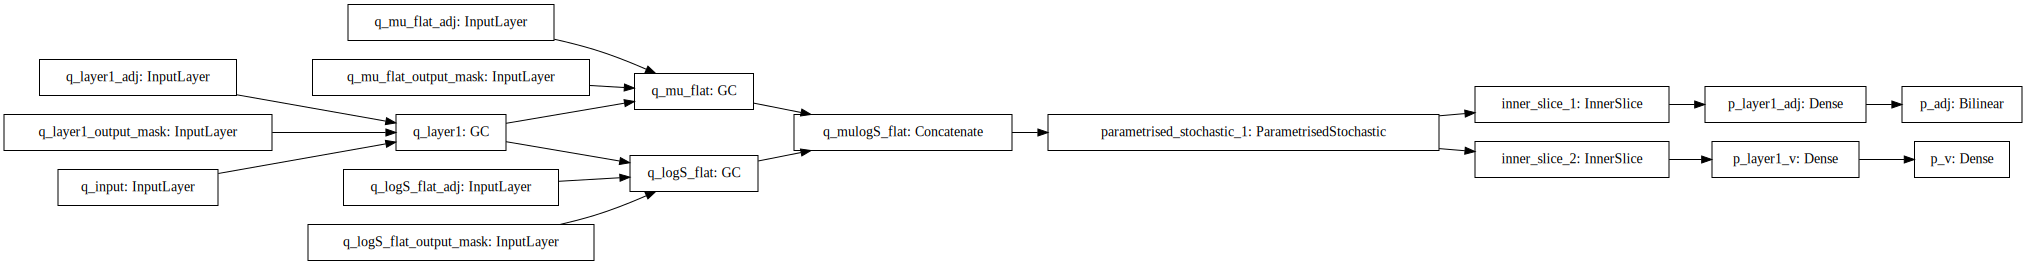

In [8]:
display(SVG(model_to_dot(vae, rankdir='LR').create(prog='dot', format='svg')))

## Before training

$\xi$ averages and distributions for each community, real and predicted adjacency matrices

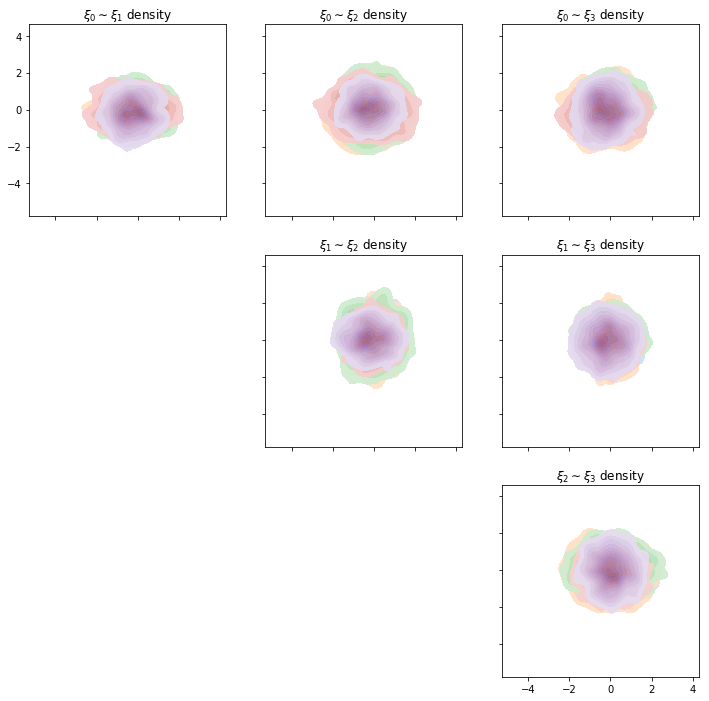

In [9]:
plot_ξ_distribution((g, l, k), q_model, q_codecs, adj, features)

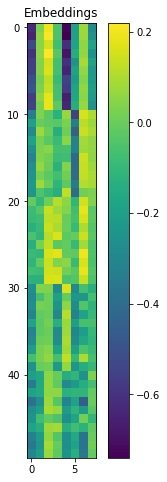

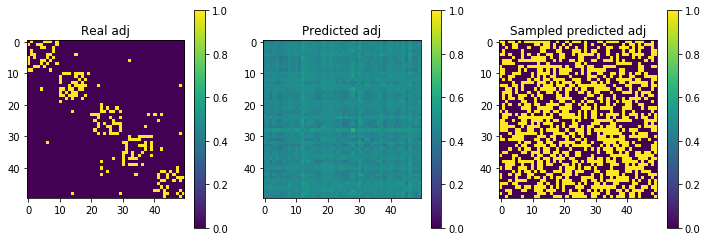

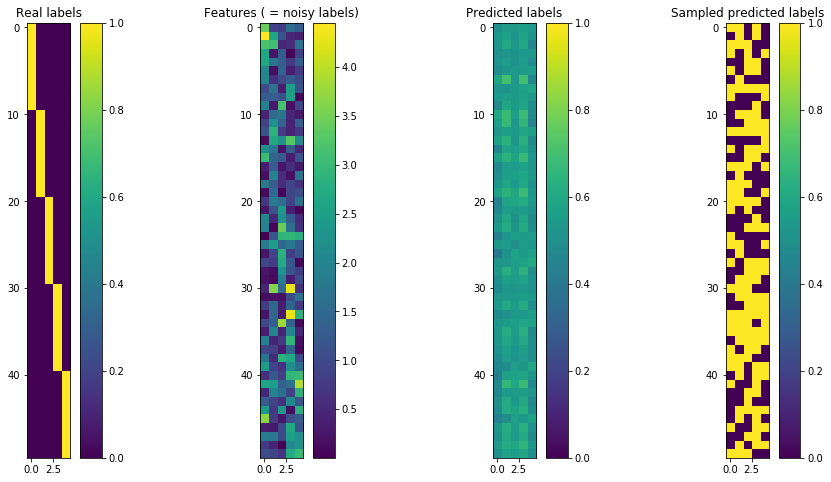

In [10]:
plot_predictions(vae, adj, features)

## Train

In [11]:
n_epochs = 5000

# Training targets
def target_func(batch_adj, required_nodes, final_nodes):
    return [
        np.zeros(1), # ignored
        utils.expand_dims_tile(utils.expand_dims_tile(batch_adj + np.eye(batch_adj.shape[0]), 0, n_ξ_samples), 0, 1),
        utils.expand_dims_tile(labels[final_nodes], 1, n_ξ_samples),
    ]

### Fullbatch

In [12]:
history = vae.fit_fullbatches(batcher_kws={'adj': adj, 'features': features, 'target_func': target_func},
                              epochs=n_epochs,
                              verbose=0, callbacks=[TQDMCallback(show_inner=False)])

/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Usually, the cell above complains with "UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.". See these for more details:
* https://stackoverflow.com/questions/35892412/tensorflow-dense-gradient-explanation#35896823
* https://stackoverflow.com/questions/39111373/tensorflow-chaining-tf-gather-produces-indexedslices-warning

### Minibatch

In [13]:
#seeds_per_batch = int(np.ceil(n_nodes / 10))
#max_walk_length = 5
#p, q = 1, 1
#neighbour_samples = None
#steps_per_epoch = int(np.ceil(n_nodes / seeds_per_batch))

In [14]:
#history = vae.fit_minibatches(batcher_kws={'adj': adj, 'features': features, 'target_func': target_func,
#                                           'seeds_per_batch': seeds_per_batch,
#                                           'max_walk_length': max_walk_length,
#                                           'p': q, 'q': q,
#                                           'neighbour_samples': neighbour_samples},
#                                 steps_per_epoch=steps_per_epoch,
#                                 epochs=n_epochs,
#                                 verbose=0, callbacks=[TQDMCallback(show_inner=False)])

Usually, the cell above complains with "UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.". See these for more details:
* https://stackoverflow.com/questions/35892412/tensorflow-dense-gradient-explanation#35896823
* https://stackoverflow.com/questions/39111373/tensorflow-chaining-tf-gather-produces-indexedslices-warning

## Training results

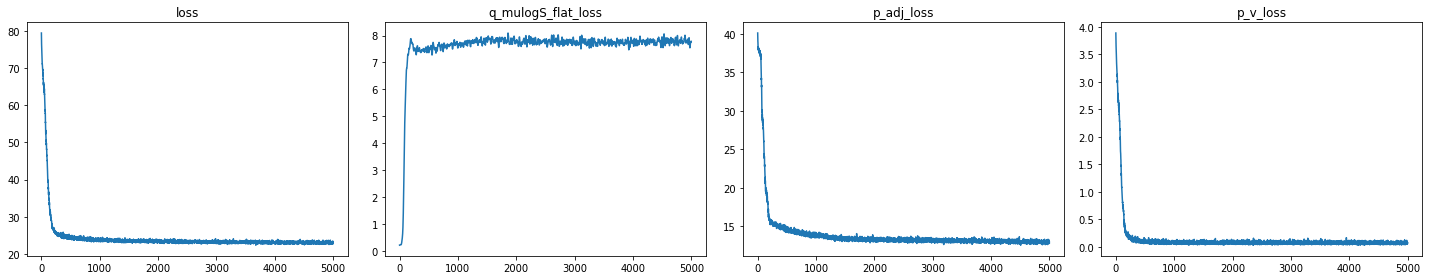

In [15]:
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

$\xi$ averages and distributions for each community, real and predicted adjacency matrices

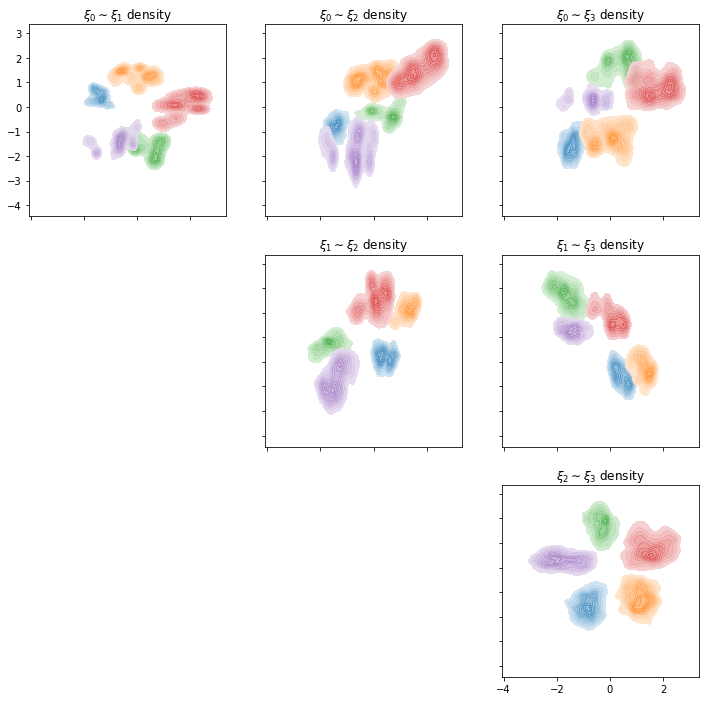

In [16]:
plot_ξ_distribution((g, l, k), q_model, q_codecs, adj, features)

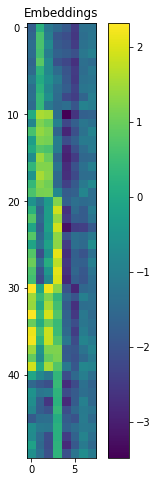

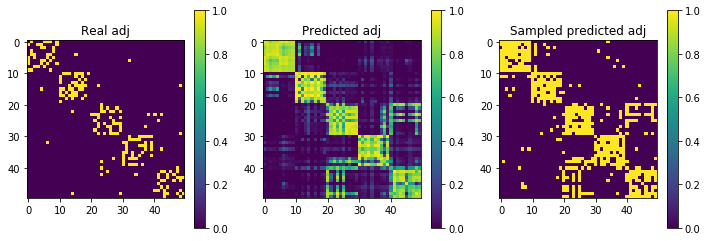

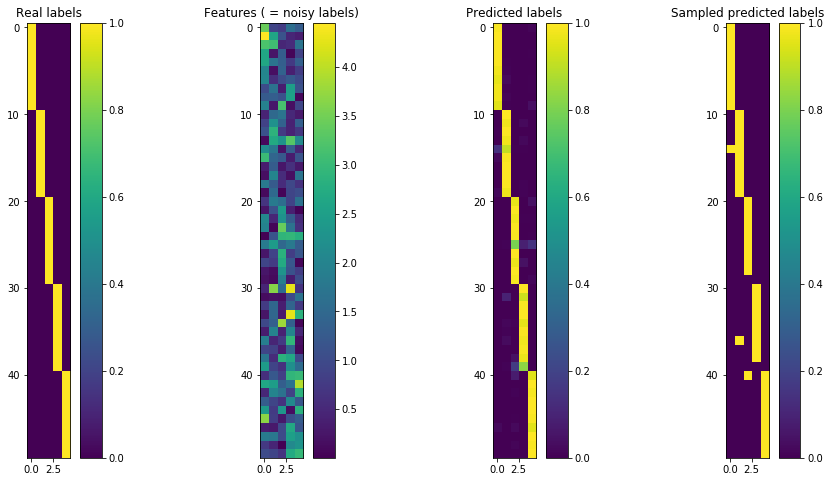

In [17]:
plot_predictions(vae, adj, features)

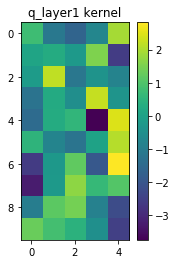

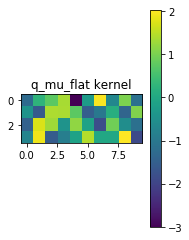

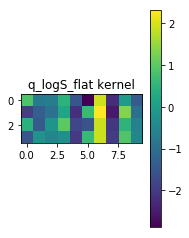

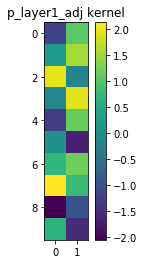

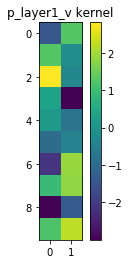

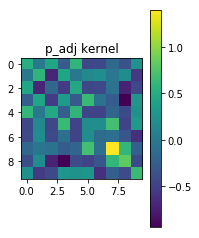

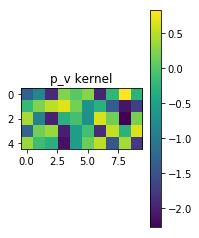

In [18]:
for layer in vae.layers:
    if hasattr(layer, 'kernel'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))#, sharey=True)
        im1 = ax1.imshow(K.eval(layer.kernel).T)
        ax1.set_title('{} kernel'.format(layer.name))
        plt.colorbar(im1, ax=ax1)
        if hasattr(layer, 'bias') and layer.bias is not None:
            im2 = ax2.imshow(K.eval(K.expand_dims(layer.bias, -1)))
            ax2.set_title('{} bias'.format(layer.name))
            plt.colorbar(im2, ax=ax2)
        else:
            ax2.set_visible(False)